###Build Pytorch neural network using high level primitives

In [ ]:
import numpy as np
from typing import Callable

####Linear model

In [ ]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

#### Non-Linear torch model
3 layers neural network using relu nonlinearity

In [ ]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden, ouput_dim):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, ouput_dim)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    r2 = self.relu1(r1)
    l2 = self.linear2(r2)
    return l2

####3d-2d nonlinear data generation

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


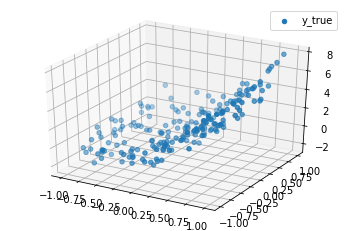

In [ ]:
n = 200
d = 3
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[3, 1, -1],[2, 0, -2],]).T
bias_true = np.array([0.5, 0.1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true[:, 0])

####Initialize tensor torch and loss for three dimention data

Define loss function. <br />
Compose nonlinear model with 3d input and 2d output, 10 neurons in hidden layer. <br />
Convert numpy arrays to tensors with auto-gred enabled, requires_grad=True

In [ ]:
loss = nn.MSELoss()

# 10 neurons for hidden layers
model = TorchModel(3, 10, 2)

x_tensor = torch.tensor(x, requires_grad=True).float()
y_true_tensor = torch.tensor(y_true, requires_grad=True).float()
y_pred_tensor = model(x_tensor)

loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(5.4278, grad_fn=<MseLossBackward>)


In [ ]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(5.4278, grad_fn=<MseLossBackward>)
tensor(4.8701, grad_fn=<MseLossBackward>)


####Train three dimention data

In [ ]:
def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    if epoch % 200 == 0:
      print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=1000)
y_pred = model(x_tensor)
y_pred = y_pred.cpu().detach().numpy()

tensor(4.8701, grad_fn=<MseLossBackward>)
tensor(0.0653, grad_fn=<MseLossBackward>)
tensor(0.0364, grad_fn=<MseLossBackward>)
tensor(0.0283, grad_fn=<MseLossBackward>)
tensor(0.0245, grad_fn=<MseLossBackward>)


#### Plot tsne function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_comparison(y_true, y_pred):
  #tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=120)
  tsne = TSNE(n_components=2, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(yt_2d[:, 0], yt_2d[:, 1], c='b', label='y_true')
  plt.scatter(yp_2d[:, 1], yp_2d[:, 1], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Comparison')
  plt.xlabel('t_SNE1')
  plt.xlabel('t_SNE2')
  plt.show()

def plot_distribution(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Distribution with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

####Plot the output and the real data using tsne

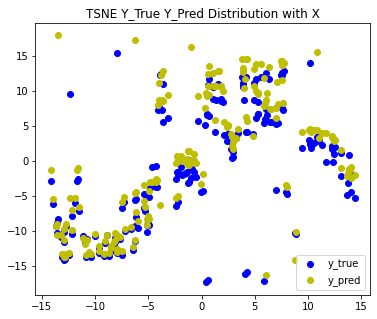

In [ ]:
plot_distribution(x, y_true, y_pred)

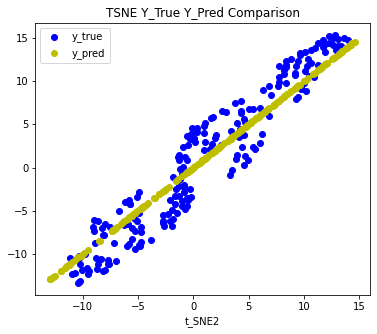

In [ ]:
plot_comparison(y_true, y_pred)

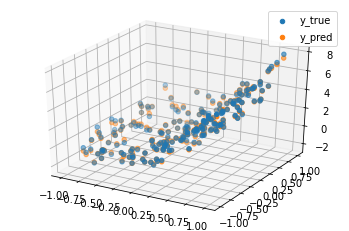

In [ ]:
plot_3d(x, y_true[:, 0], y_pred=y_pred[:, 0])